# Images

This tutorial will show how to load, manipulate and display images, using opencv, numpy and matplotlib.

We'll first import the libraries we'll use in this tutorial:

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 

## Loading and displaying images

We'll first start off by loading an image, and looking at what result we get. For this we'll use opencv's `imread` function.

In [42]:
image = cv2.imread("car.jpg")
print("Image shape", image.shape)
print("Image datatype", image.dtype)

Image shape (512, 512, 3)
Image datatype uint8


We notice that the image is a 512x512x3 numpy array, and it's datatype is `uint8`.

This image is a 512x512 RGB image, and each pixel consists of 3 8-bit unsigned integer values. These contain the red, green and blue colour channels of the image. Since they are 8-bit values, they can contain integer values from 0 to 255 only.

The array has 3 dimensions, which contain the 512 rows, 512 columns and 3 channels of the image, giving the shape (512, 512, 3) above.

If we want to display this image, we can use matplotlib's `imshow` function.

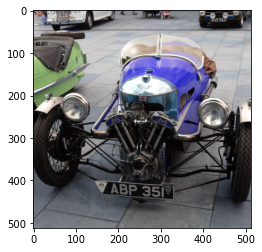

In [43]:
plt.imshow(image)
plt.show()

Right away there is a bit of an issue. This car is really red, but when we displayed it above it was blue. This is because opencv loads images in BGR format by default. However, `imshow` in matplotlib expects RGB input. We can convert it simply by changing the order of the channels, but alternatively opencv has a built in function `cvtColor` for converting colours.

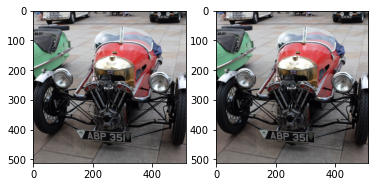

In [44]:
# Manually reversing the order of the channels.
image_rgb = np.zeros_like(image)
image_rgb[:,:,0] = image[:,:,2]
image_rgb[:,:,1] = image[:,:,1]
image_rgb[:,:,2] = image[:,:,0]

plt.subplot(1,2,1)
plt.imshow(image_rgb)

# Using opencv's built-in colour conversion function.
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.subplot(1,2,2)
plt.imshow(image_rgb)
plt.show()

This function `cvtColor` can convert to a wide range of different colourspaces, and is useful for a wide range of applications:

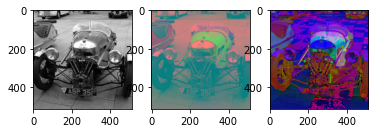

In [45]:
# Converting to grayscale
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.subplot(1,3,1)
plt.imshow(image_gray, cmap="gray", vmin=0, vmax=255) #Note we have to set the colourmap to "gray" and the min and max values here.

# Converting to YCrCb (Decorrelated colourspace with Y intensity, Cb and Cr chroma channels)
image_ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
plt.subplot(1,3,2)
plt.imshow(image_ycrcb)

# Converting to HSV (hue, saturation, value)
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
plt.subplot(1,3,3)
plt.imshow(image_hsv)

Note that when showing the grayscale image above, we had to set `cmap="gray"` and `vmin=0, vmax=255`.

This is because by default, when given 2D input, `imshow` will show a false-colour image:

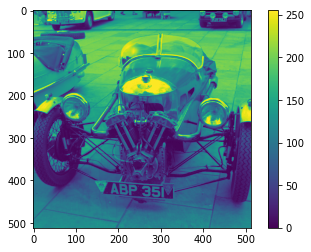

In [46]:
plt.imshow(image_gray)
plt.colorbar() # Shows a colorbar, indicating what each false color corresponds to.
plt.show()

This can be useful for displaying error maps and the like, but it's important to remember this when you just want to display greyscale images.

## Image datatypes

The image we just loaded is in RGB888 format, with each pixel value stored as 3 8-bit unsigned integer values.

This is compact, which is useful when saving images to disk. However, when manipulating images they often don't work well, causing loss of precision or overflow.

For this reason we often convert to a floating-point format before working on images.

When an image is in a format like float32, the values are normally rescaled to lie in the range [0,1]. We do this by dividing by 255 as below:

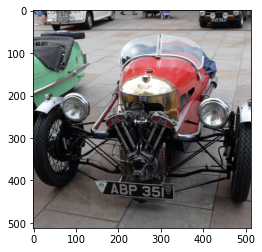

In [47]:
image_float = image_rgb.astype(np.float32) / 255. 
# image_float now contains 32-bit floating-point values in the range [0,1].
# Functions like imshow() will work with this as normal:
plt.imshow(image_float)
plt.show()

## Denoising example

Opencv and numpy contain a wide range of functions for image manipulation and computer vision. 

To show how they can be used, and how matplotlib can be used to plot and visualise the results, we'll run through a quick example of a common image processing task: Denoising.

We'll start off by adding some noise to our image, to get an input we can denoise.

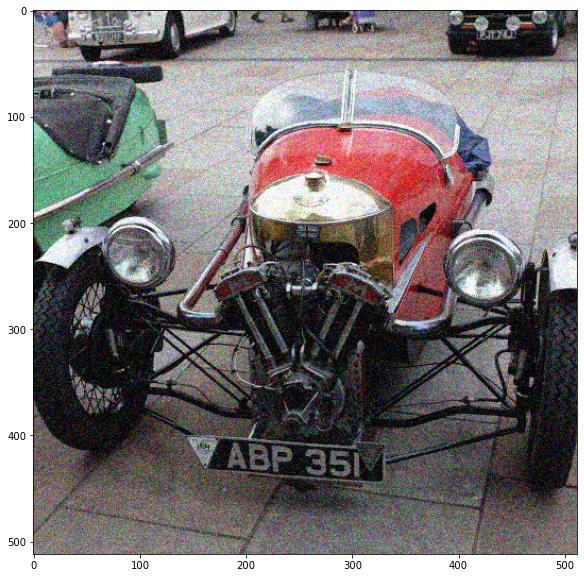

In [48]:
noisy_image = image_float + np.random.normal(scale=0.10, size=image.shape).astype(np.float32) # Add gaussian noise of stdev 0.1
noisy_image[noisy_image > 1.0] = 1.0 # Set any values above 1.0 to 1.0
noisy_image[noisy_image < 0.0] = 0.0 # Set any values below 0.0 to 0.0
# Now we have a noisy image in the range [0, 1]

plt.figure(figsize=[10,10]) # Make figure bigger so noise is visible
plt.imshow(noisy_image)
plt.show()

We'll try denoising this with a [bilateral filter](https://users.soe.ucsc.edu/~manduchi/Papers/ICCV98.pdf). This is a common image filter which tries to blur in a conservative way, avoiding destroying strong edges in the input.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


float32


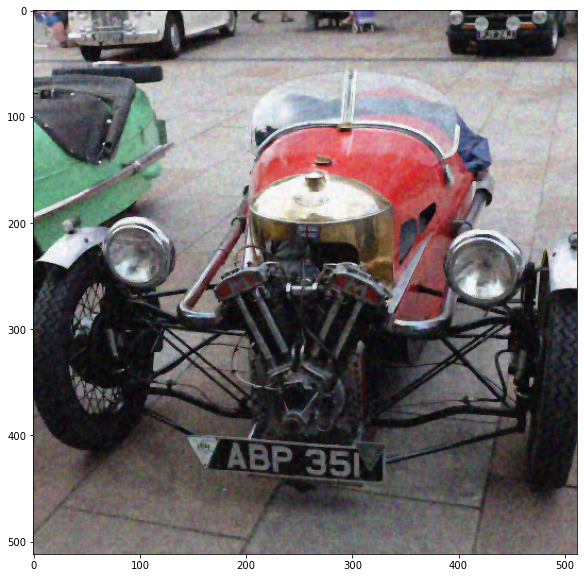

In [49]:
print(noisy_image.dtype)
denoised_image = cv2.bilateralFilter(noisy_image, d=5, sigmaColor=0.5, sigmaSpace=3.0)

plt.figure(figsize=[10,10])
plt.imshow(denoised_image)
plt.show()

That seems less noisy. We can try to get a better idea of how well it worked by plotting an error map.

We'll do this by measuring the difference at each pixel in colour space, giving us a 512x512 array. We can then show a false colour plot of this using `plt.imshow()`.

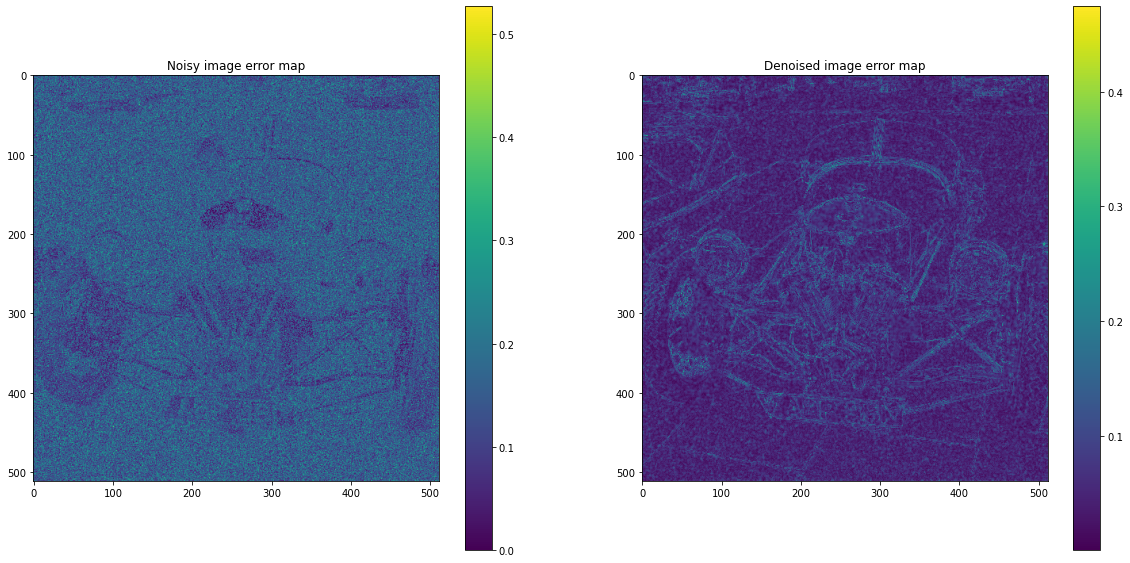

In [50]:
def make_error_map(image, gt_image):
    sq_diff = 0
    for c in range(3):
        diff = image[...,c] - gt_image[...,c]
        sq_diff += diff * diff
    return np.sqrt(sq_diff)

# Make error map for noisy image
noisy_errmap = make_error_map(noisy_image, image_float)

# Make error map for denoised image
denoised_errmap = make_error_map(denoised_image, image_float)

plt.figure(figsize=[20,10])

plt.subplot(1,2,1)
plt.title("Noisy image error map")
plt.imshow(noisy_errmap)
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Denoised image error map")
plt.imshow(denoised_errmap)
plt.colorbar()

plt.show()

From this error map it's clear to see that the denoised image has less error overall, and we can also see that the error that remains is concentrated at strong edges in the image.

This may mean that the parameters of the bilateral filter could be adjusted to better preserve the edges and get an improved result.

If we want to quantify how much the denoising has helped, we could use a metric like Mean Squared Error (MSE):

In [51]:
def mean_squared_error(image, gt_image):
    diff = image - gt_image
    return np.mean(diff * diff)

print("MSE of noisy image", mean_squared_error(noisy_image, image_float))
print("MSE of denoised image", mean_squared_error(denoised_image, image_float))

MSE of noisy image 0.0089647
MSE of denoised image 0.001723891


As we can see, the MSE of the denoised image is substantially lower. 